In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.utils.tensorboard
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
import pretrainedmodels
from catalyst.utils import set_global_seed, prepare_cudnn
from catalyst.dl.runner import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, AUCCallback, F1ScoreCallback
from catalyst.dl.utils.visualization import plot_metrics
from catalyst.utils.torch import get_available_gpus

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="5"


In [20]:
SEED = 42
set_global_seed(SEED)
prepare_cudnn(deterministic=True)
model_name = 'densenet121'
num_classes = 7
NUM_EPOCHS = 10
BATCH_SIZE = 32


In [4]:
model_fn = pretrainedmodels.__dict__[model_name]
model = model_fn(num_classes=1000, pretrained='imagenet').cuda()
model.last_linear = nn.Linear(1024, num_classes)
model = torch.nn.DataParallel(model, device_ids=[0]).cuda()


In [5]:
from catalyst.dl import utils
device = utils.get_device()
print(f"device: {device}")
runner = SupervisedRunner(device=device)
logdir = "./logs/trial"

device: cuda


In [6]:
import pandas as pd
filname = 'fer2013.csv'
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
names=['emotion','pixels','usage']
df=pd.read_csv('fer2013.csv',names=names, na_filter=False)
im=df['pixels']
df.head(10)


,emotion,pixels,usage
0,emotion,pixels,Usage
1,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
2,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
3,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
4,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
5,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
6,2,55 55 55 55 55 54 60 68 54 85 151 163 170 179 ...,Training
7,4,20 17 19 21 25 38 42 42 46 54 56 62 63 66 82 1...,Training
8,3,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
9,3,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [8]:
def getData(filname):
     # images are 48x48
     # N = 35887
     Y = []
     X = []
     first = True
     for line in open(filname):
         if first:
             first = False
         else:
             row = line.split(',')
             Y.append(int(row[0]))
             X.append([int(p) for p in row[1].split()])
     X, Y = np.array(X) / 255.0, np.array(Y)
     return X, Y

In [9]:
X, Y = getData(filname)
num_class = len(set(Y))
print(num_class)

7


In [10]:
N, D = X.shape
X = X.reshape(N, 48, 48)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state =42)


In [14]:
from PIL import Image
from torch.utils.data import Dataset
class my_dataset(Dataset):
     def __init__(self, x, y, transform=None):
         """
         Args:
         csv_file (string): Path to the csv file with annotations.
         root_dir (string): Directory with all the images.
         transform (callable, optional): Optional transform to be applied
         on a sample.
         """
         self.x = x
         self.y = y
         self.transform = transform
     def __len__(self):
         return len(self.x)
     def __getitem__(self, idx):
         fft_p = (X_train[idx]*255).astype(np.uint8)
         image = Image.fromarray(fft_p)
         image = self.transform(image)
         sample = (image, self.y[idx])


         return sample

In [17]:
imsize = 224
trans = transforms.Compose([transforms.Resize(imsize),
 transforms.Grayscale(num_output_channels=3),
 transforms.ToTensor(),
 ])
data_train = my_dataset(X_train,y_train,trans)
data_test = my_dataset(X_test,y_test,trans)
trainloader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_SIZE,  num_workers =4)
testloader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_SIZE, num_workers =4)

tensor(2)


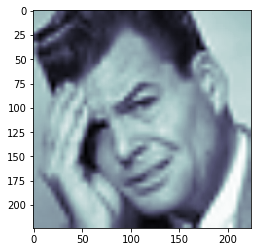

In [18]:
batch = next(iter(testloader))
images, label= batch
ids = random.choice(range(BATCH_SIZE))
plt.imshow(images[ids][0], cmap='bone')
print(label[ids])
plt.show()


In [19]:
loaders = {"train":trainloader, "valid": testloader}
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.9, 0.999),
 eps=1e-08, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
 mode='min',
factor=0.1,
patience=3
 )

In [ ]:
runner.train(
     model=model,
     logdir=logdir,
     criterion=criterion,
     optimizer=optimizer,
     scheduler=scheduler,
     loaders=loaders,
     num_epochs=NUM_EPOCHS,
     # We can specify the callbacks list for the experiment;
     # For this task, we will check Accuracy
     callbacks=[
        # F1ScoreCallback(
        # input_key = "targets",
        # output_key = 'logits',
        # prefix = 'f1_score',
        # beta = 1.0,
        # eps = 1e-07,
        # threshold = None,
        # activation=None,
        # ),

         AccuracyCallback(
             input_key="targets",
             output_key='logits',
             prefix='accuracy',
             num_classes=num_classes,
             activation=None,
         ),
     ],
     verbose=True,
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1/10 * Epoch (train): 100% 898/898 [03:35<00:00,  4.16it/s, accuracy01=20.000, accuracy03=80.000, accuracy05=80.000, loss=2.215]  
1/10 * Epoch (valid): 100% 225/225 [00:16<00:00, 13.99it/s, accuracy01=20.000, accuracy03=50.000, accuracy05=80.000, loss=3.547]   
[2020-04-02 22:45:52,649] 
1/10 * Epoch 1 (train): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=702.9244 | _timers/batch_time=0.0483 | _timers/data_time=0.0093 | _timers/model_time=0.0390 | accuracy01=57.7304 | accuracy03=87.0253 | accuracy05=97.4374 | loss=1.1260
1/10 * Epoch 1 (valid): _base/lr=0.0001 | _base/momentum=0.9000 | _timers/_fps=984.1881 | _timers/batch_time=0.0385 | _timers/data_time=0.0106 | _timers/model_time=0.0279 | accuracy01=17.8944 | accuracy03=48.5000 | accuracy05=79.3278 | loss=3.2593
2/10 * Epoch (train):  78% 703/898 [02:55<00:50,  3.88it/s, accuracy01=75.000, accuracy03=93.750, accuracy05=93.750, loss=0.752]  